In [11]:
import pandas as pd
import numpy as np

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

---------------------

In [13]:
# Cargar dataset curado
recup = pd.read_csv('./curados/para_reg.csv')

In [14]:
# Ver las columnas del dataset
recup.columns

Index(['tramite_tipo', 'tramite_fecha', 'fecha_inscripcion_inicial',
       'registro_seccional_descripcion', 'registro_seccional_provincia',
       'automotor_origen', 'automotor_anio_modelo',
       'automotor_tipo_descripcion', 'automotor_marca_descripcion',
       'automotor_modelo_descripcion', 'automotor_uso_descripcion',
       'titular_tipo_persona', 'titular_domicilio_localidad',
       'titular_domicilio_provincia', 'titular_genero',
       'titular_anio_nacimiento', 'titular_pais_nacimiento', 'unico_duenio',
       'fecha_recup', 'dias'],
      dtype='object')

In [15]:
# Ver como son los datos en el dataset
recup.head(1)

,tramite_tipo,tramite_fecha,fecha_inscripcion_inicial,registro_seccional_descripcion,registro_seccional_provincia,automotor_origen,automotor_anio_modelo,automotor_tipo_descripcion,automotor_marca_descripcion,automotor_modelo_descripcion,automotor_uso_descripcion,titular_tipo_persona,titular_domicilio_localidad,titular_domicilio_provincia,titular_genero,titular_anio_nacimiento,titular_pais_nacimiento,unico_duenio,fecha_recup,dias
0,DENUNCIA DE ROBO O HURTO,2018-01-11,1988-09-06,ESTEBAN ECHEVERRIA Nº 1,Buenos Aires,Nacional,1988.0,FURGON,FORD,F-100,Privado,Física,LUIS GUILLON,BUENOS AIRES,Masculino,1988.0,ARGENTINA,1.0,2019-01-29,383 days 00:00:00.000000000


In [16]:
# Definir una función para extraer solo los días como int del objeto timedate 
def daysonly(dias):
    return int(dias.split(' ')[0])

In [17]:
# Genero una nueva columna donde el dato es solo la cantidad de dias como int
recup['dias_'] = recup['dias'].apply(daysonly)

In [18]:
# arrastramos un problema del curado del dataset, figuran algunos valores en la columna "uso descripción" como 'No declarado'
recup['automotor_uso_descripcion'].value_counts()

Privado         746
Público           8
No declarado      2
Name: automotor_uso_descripcion, dtype: int64

In [19]:
# elimino los samples con automotor_uso_descripcion "no declarado" -- SON DOS SAMPLES
recup = recup[recup['automotor_uso_descripcion'] != 'No declarado']

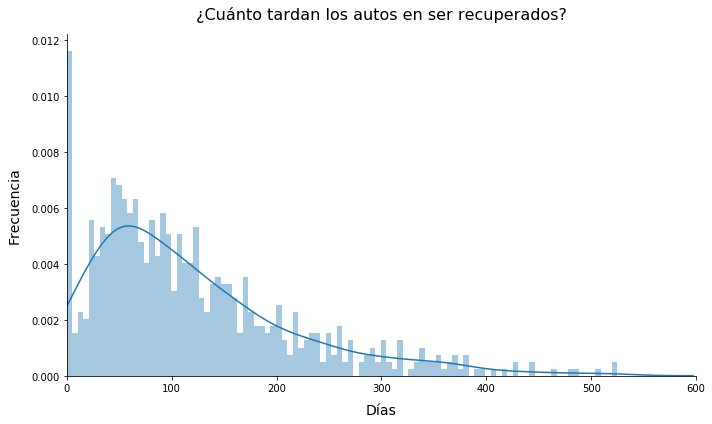

In [20]:
# Generar un histograma de la distrución de días de recuperación
plt.figure(figsize= (10,6))
sns.distplot(recup.dias_, bins= 100)
plt.title('¿Cuánto tardan los autos en ser recuperados?', pad= 15, fontsize= 16)
plt.xlabel('Días', labelpad = 10, fontsize= 14)
plt.ylabel('Frecuencia', labelpad= 10, fontsize= 14)
plt.xlim(0,600)
sns.despine()
plt.tight_layout()
#plt.savefig('./figs/tiempo_recu.png', dpi= 300)

In [21]:
# las samples con 0 días para el recupero son conflictivas, vamos a eliminarlas
recup = recup[recup['dias_'] != 0]

In [22]:
# Ver los descriptores de la distribución 
recup.dias_.describe()

count    720.000000
mean     125.726389
std       96.290670
min        1.000000
25%       55.000000
50%       99.500000
75%      169.000000
max      525.000000
Name: dias_, dtype: float64

------------------------

# limpieza de features y feature engineering/ extraction

In [23]:
# Ver columnas
recup.columns

Index(['tramite_tipo', 'tramite_fecha', 'fecha_inscripcion_inicial',
       'registro_seccional_descripcion', 'registro_seccional_provincia',
       'automotor_origen', 'automotor_anio_modelo',
       'automotor_tipo_descripcion', 'automotor_marca_descripcion',
       'automotor_modelo_descripcion', 'automotor_uso_descripcion',
       'titular_tipo_persona', 'titular_domicilio_localidad',
       'titular_domicilio_provincia', 'titular_genero',
       'titular_anio_nacimiento', 'titular_pais_nacimiento', 'unico_duenio',
       'fecha_recup', 'dias', 'dias_'],
      dtype='object')

In [24]:
# Eliminar las columnas que tienen demasiados valores diferentes, redundan información o no sirven
recup.drop(['tramite_tipo', 'registro_seccional_descripcion', 'titular_domicilio_localidad',
            'dias', 'fecha_recup'], axis= 1, inplace = True)

In [25]:
# Ver qué columnas quedaron
recup.columns

Index(['tramite_fecha', 'fecha_inscripcion_inicial',
       'registro_seccional_provincia', 'automotor_origen',
       'automotor_anio_modelo', 'automotor_tipo_descripcion',
       'automotor_marca_descripcion', 'automotor_modelo_descripcion',
       'automotor_uso_descripcion', 'titular_tipo_persona',
       'titular_domicilio_provincia', 'titular_genero',
       'titular_anio_nacimiento', 'titular_pais_nacimiento', 'unico_duenio',
       'dias_'],
      dtype='object')

In [26]:
# Cambiar las columnas que tienen fechas a formato datetime
recup['tramite_fecha'] = pd.to_datetime(recup['tramite_fecha'])
recup['fecha_inscripcion_inicial'] = pd.to_datetime(recup['fecha_inscripcion_inicial'])

Generamos varias features extra que finalmente no utilizamos por que no mejoraban la performance del modelo:

- Extraer día de la semana de la fecha del robo:
   
   `recup['dia_robo'] = recup['tramite_fecha'].apply(lambda x: int(x.isoweekday())) #lunes es 1, domingo 7`
- Extraer día del año (1-365) de la fecha del robo:
   
   `#recup['dia_del_anio'] = recup['tramite_fecha'].apply(lambda x: int(x.timetuple().tm_yday))`
- Extraer año de patentamiento (varia colinealmente con año modelo, no sirve)
   
   `#recup['anio_pat'] = recup['fecha_inscripcion_inicial'].apply(lambda x: int(x.year))`
- Cambiar año de nacimiento del titular a int
   
   `#recup['titular_anio_nacimiento'] = recup['titular_anio_nacimiento'].astype(int)`

In [27]:
# Generar columna 'mes_robo' extrayendo el mes de la fecha de trámite
recup['mes_robo'] = recup['tramite_fecha'].apply(lambda x: int(x.month))

In [28]:
# Pasar a mayúsculas la columna registro_seccional_provincia para poder compararla con 'titular_domicilio_provincia'
# y generar una columna nueva que indique si el auto fue radicado en la misma provincia de origen del dueño
recup['registro_seccional_provincia'] = recup['registro_seccional_provincia'].apply(lambda x: x.upper()) 
recup['tit_radicado'] = (recup['registro_seccional_provincia'] == recup['titular_domicilio_provincia']).astype(int)
# Cambiar automotor_anio_modelo a int
recup['automotor_anio_modelo'] = recup['automotor_anio_modelo'].astype(int)

In [29]:
# Eliminar las columnas originales a partir de las cuales generamos las nuevas features
recup.drop(['tramite_fecha', 'fecha_inscripcion_inicial', 'titular_domicilio_provincia', 'titular_anio_nacimiento'], axis = 1, inplace= True)

In [30]:
# Generar columnas categóricas para titular masculino, uso privado/público, auto importado/nacional
recup['titular_masculino'] = np.where(recup['titular_genero'] == 'Masculino', 1, 0)
recup['uso_privado'] = np.where(recup['automotor_uso_descripcion'] == 'Privado', 1, 0)
recup['Importado'] = np.where(recup['automotor_origen'] == 'Importado', 1, 0) # Nacional y prot 21 son virtualmente lo mismo

In [53]:
# Ver como quedaron las columnas
recup.head(1)

,registro_seccional_provincia,automotor_origen,automotor_anio_modelo,automotor_tipo_descripcion,automotor_marca_descripcion,automotor_modelo_descripcion,automotor_uso_descripcion,titular_tipo_persona,titular_genero,titular_pais_nacimiento,unico_duenio,dias_,mes_robo,tit_radicado,titular_masculino,uso_privado,Importado
0,BUENOS AIRES,Nacional,1988,FURGON,FORD,F-100,Privado,Física,Masculino,ARGENTINA,1.0,383,1,1,1,1,0


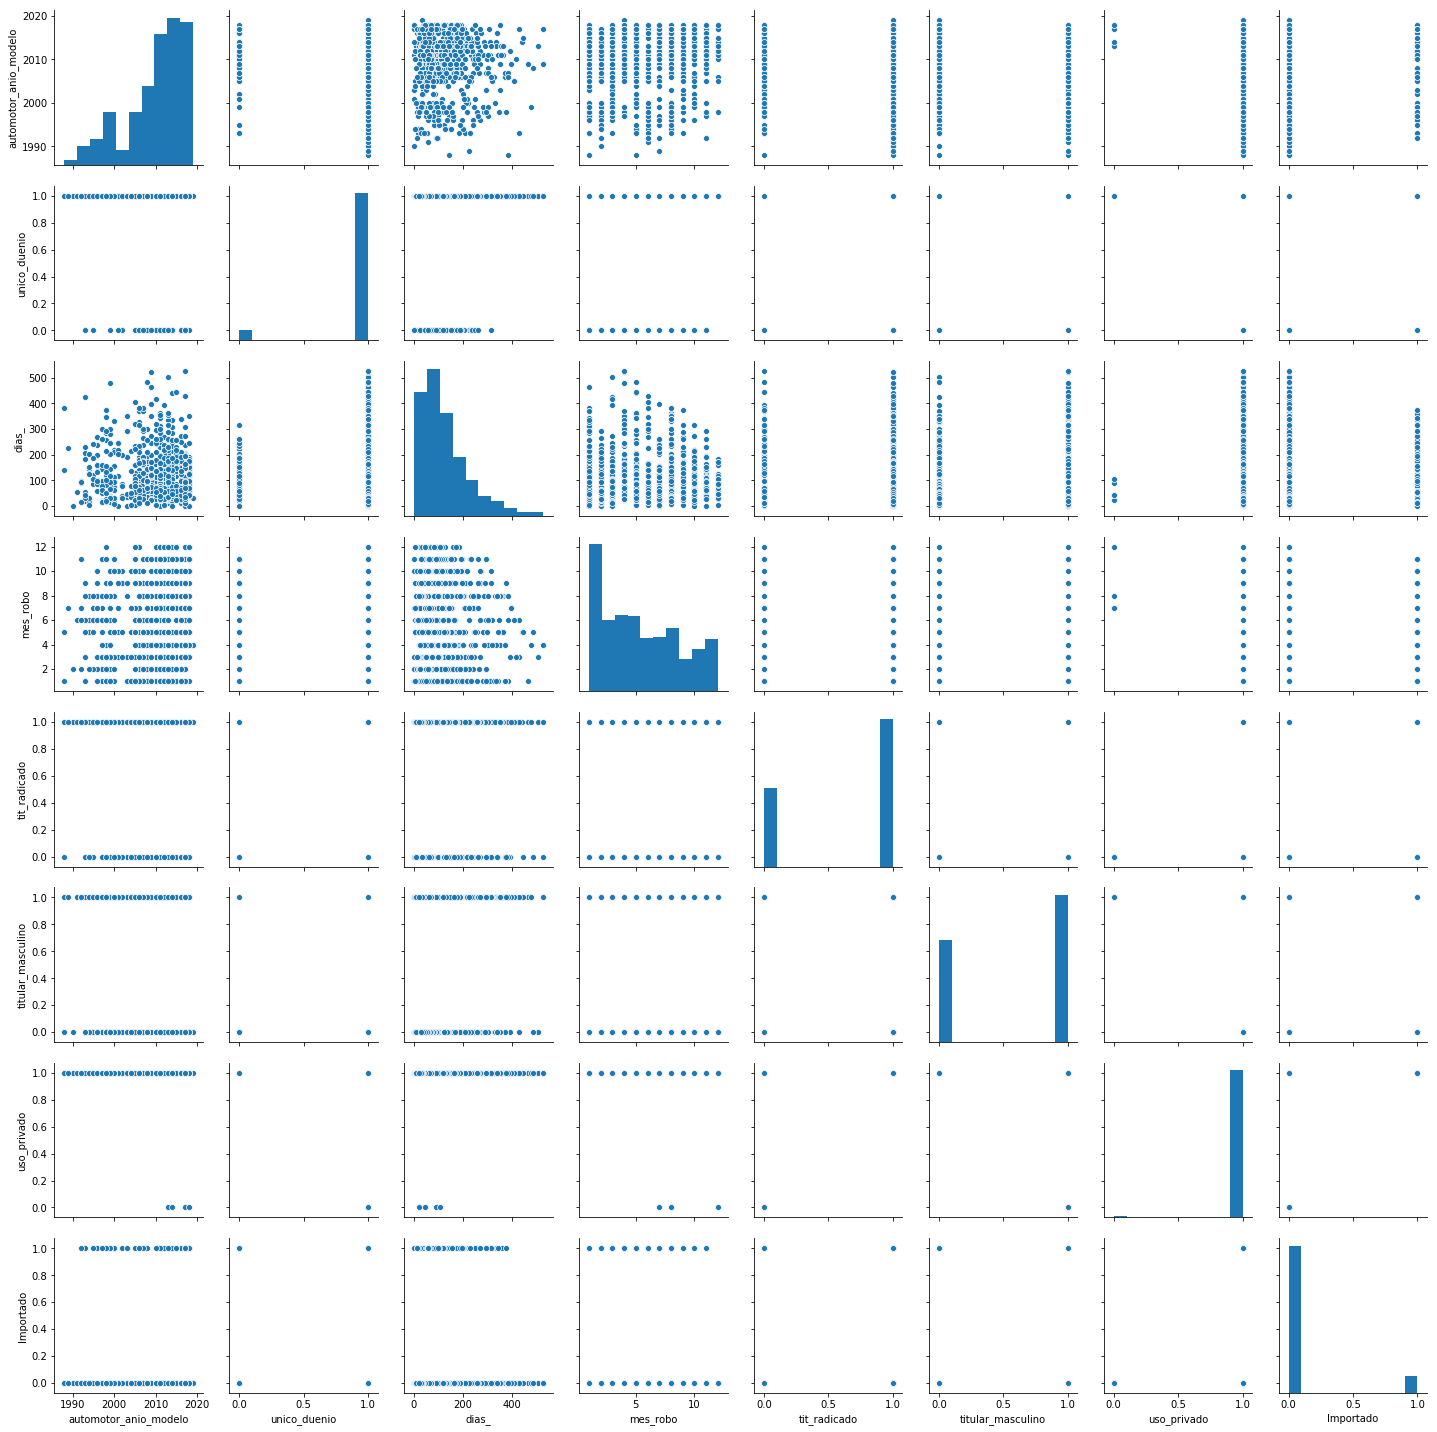

In [54]:
# Hacer un pairplot con las features como quedaron hasta este punto 
# (a partir de uno previo se eliminarion las features mencionadas anteriormente)
sns.pairplot(recup)
plt.savefig('./pairreg_predummie.png', dpi= 300)

Generamos varios dummies extra que finalmente no utilizamos por que no mejoraban la performance del modelo:

- Tipo de automotor y marca están implícitos en modelo, además los modelos elegidos tienen una mejor performance cuando estas features no están presentes
   
   `tipo_dummie= pd.get_dummies(recup.automotor_tipo_descripcion)`
   
   `marca_dummie= pd.get_dummies(recup.automotor_marca_descripcion)`
- El país del titular del auto no mejora la performance de los modelos:

   `pais_tit_dummie = pd.get_dummies(recup.titular_pais_nacimiento)`

In [31]:
# Generar dummies para las features con más de dos categorías
prov_dummie= pd.get_dummies(recup.registro_seccional_provincia)
modelo_dummie= pd.get_dummies(recup.automotor_modelo_descripcion)

In [32]:
# Eliminar la última columna de todos los dummies porque ya está explicada por el resto, generaría variables que tienen colinearidad
prov_dummie.drop(prov_dummie.columns[-1], axis = 1, inplace = True)
modelo_dummie.drop(modelo_dummie.columns[-1], axis = 1, inplace = True)

In [33]:
# unir los dummies al dataframe principal
recup = recup.join([prov_dummie, modelo_dummie])

In [34]:
# Eliminar todas las columnas que fueron reemplazadas por dummies, sobran o no serán utilizadas
recup.drop(['registro_seccional_provincia', 'automotor_origen', 'automotor_uso_descripcion','automotor_tipo_descripcion',
        'automotor_marca_descripcion', 'automotor_modelo_descripcion','titular_pais_nacimiento', 
       'titular_tipo_persona', 'titular_genero'], axis= 1, inplace = True) # sacar anio_pat, 

In [35]:
# Ver que features quedaron
recup.columns

Index(['automotor_anio_modelo', 'unico_duenio', 'dias_', 'mes_robo',
       'tit_radicado', 'titular_masculino', 'uso_privado', 'Importado',
       'BUENOS AIRES', 'CHUBUT',
       ...
       'SPRINTER', 'STRADA', 'SURAN', 'TAKE', 'TIGGO', 'TIIDA', 'TRACKER',
       'UNO', 'VECTRA', 'VENTO'],
      dtype='object', length=104)

--------------------

# Dividir en variable a predecir (y) y matriz de features (X)

In [36]:
# La variable a predecir son los días que tarda el auto en ser recuperado
y = recup.dias_

In [37]:
# El resto serán las features a utilizar para predecir
X = recup.drop('dias_', axis = 1)

-------------

## Accesorio

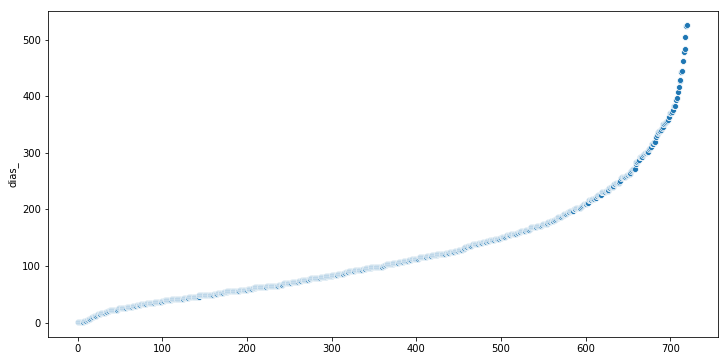

In [62]:
# Ordenar los días de manera creciente para visualizar
plt.figure(figsize= (12,6))
sns.scatterplot(range(1,len(y) + 1), y.sort_values())

In [63]:
#ver como correlacionan las variables numéricas con y(dias_)
recup[['automotor_anio_modelo','unico_duenio', 'mes_robo', 'titular_masculino', 
       'tit_radicado', 'uso_privado', 'Importado']].corrwith(recup['dias_'])

automotor_anio_modelo   -0.055841
unico_duenio             0.037230
mes_robo                -0.019626
titular_masculino        0.052140
tit_radicado             0.059226
uso_privado              0.064204
Importado                0.060948
dtype: float64

(-0.4, 0.4)

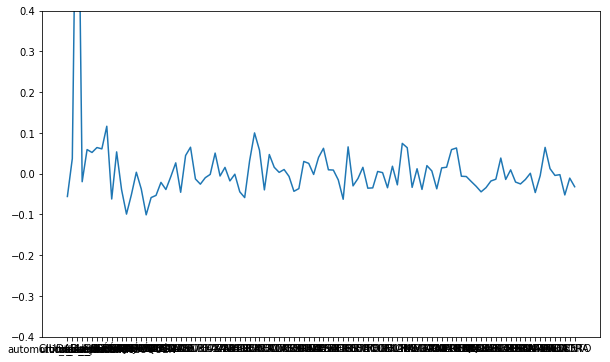

In [64]:
# Ver como correlacionan todas las features con el valor a predecir
plt.figure(figsize= (10,6))
plt.plot(recup.corrwith(recup.dias_))
plt.ylim(-0.4, 0.4)

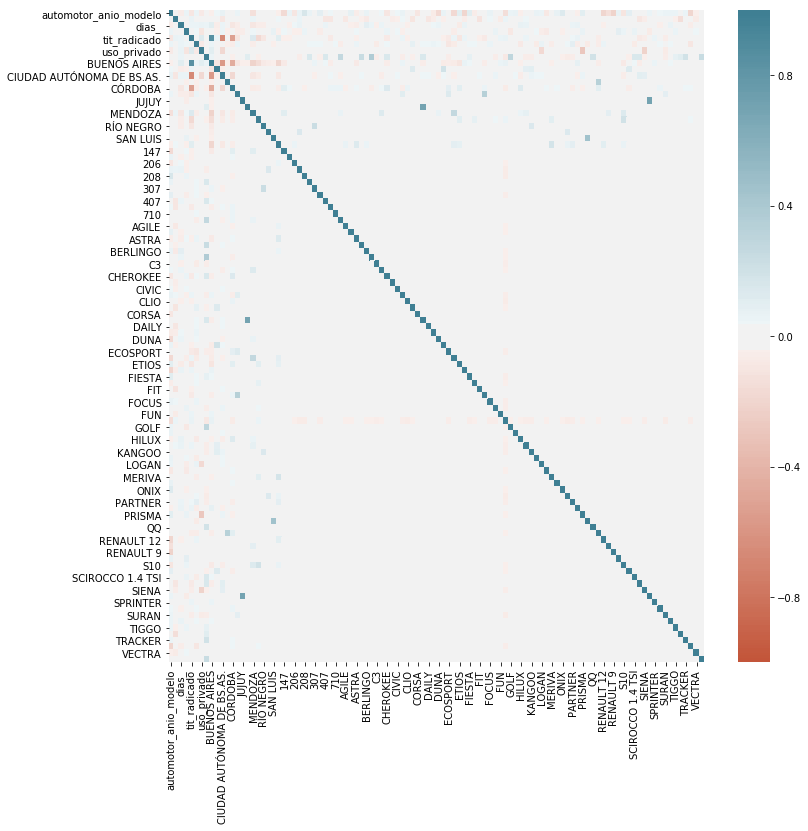

In [56]:
# Matriz de correlacion entre las features
plt.figure(figsize= (12,12))
sns.heatmap(recup.corr(), vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(20, 220, n=200))

----------------

# Regresión y predicción

### Imports de librerías de regresión

In [38]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
#from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor as rfr

## train_test split y escalado

In [39]:
# Generar bins para poder estratificar la variable continua y tener representados todos los valores en el train test
# Evitar que haya sobrerepresentado algún rango de valores
bins = np.linspace(0, max(y)+ 1, 25) #bines copados 25
y_binned = np.digitize(y, bins)

In [144]:
# Train test split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=7, stratify= y_binned) #copado es 0.3 y 7

In [145]:
# Escalo con el Xtrain
scaler = preprocessing.StandardScaler().fit(Xtrain)
Xtrain_scal = scaler.transform(Xtrain)  
Xtest_scal = scaler.transform(Xtest)  

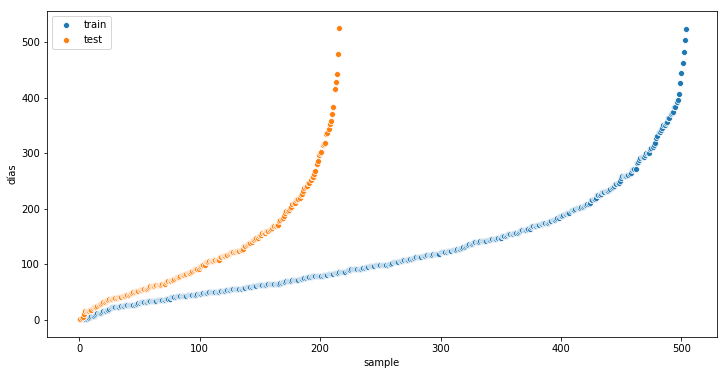

In [143]:
# Ver como quedaron divididos los train y test sets para la variable a predecir (cubre todo el rango)
plt.figure(figsize= (12,6))
sns.scatterplot(range(1,len(ytrain) + 1), ytrain.sort_values(), label= 'train')
sns.scatterplot(range(1,len(ytest) + 1), ytest.sort_values(), label = 'test')
plt.xlabel('sample')
plt.ylabel('días')
plt.legend()

## LINEAR REGRESSION

In [53]:
#linear regression simple
# Generar el objeto regresor
lr = LinearRegression()

In [54]:
# fitear el regresor a los datos
lr.fit(Xtrain_scal, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [55]:
# Generar las predicciones
ypred = lr.predict(Xtest_scal)

In [56]:
# Calcular el RMSE
np.sqrt(metrics.mean_squared_error(ytest, ypred))

1329723541953425.5

In [157]:
sns.set_style('whitegrid')

Text(0.5, 0, 'predicción')

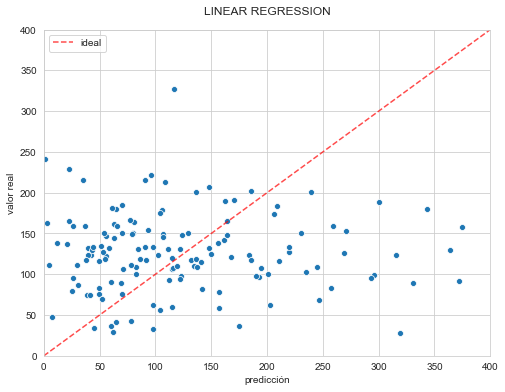

In [168]:
# Ver como es la comparación de los datos de predicción con los datos de test
plt.figure(figsize= (8,6))
sns.scatterplot(ytest, ypred)
plt.plot((0,400), (0,400), '--', color= 'r', alpha= 0.7, label= 'ideal')
plt.ylim(0,400) # hay outliers fuera de rango
plt.xlim(0,400)
plt.legend()
plt.title('LINEAR REGRESSION' , pad= 15)
plt.ylabel('valor real')
plt.xlabel('predicción')

Text(0.5, 1.0, 'residuals range: -1.5956682503441108e+16 - 386.74, \n mean:-110810295162785.19, median: -19.94')

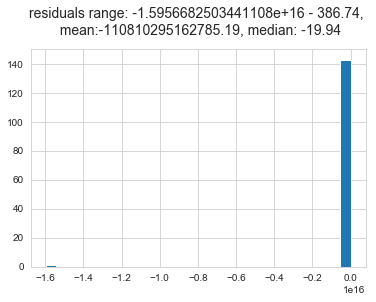

In [182]:
# ver cómo es la distribución de los residuales 
# si la predicción es buena deberían tener una distribución aproximadamente normal centrada en 0
diff = ytest - ypred
diff.hist(bins= 30)
plt.title(f'residuals range: {np.round(min(diff),2)} - {np.round(max(diff),2)}, \n mean:{np.round(np.mean(diff), 2)}, median: {np.round(np.median(diff), 2)}',
         pad= 15, fontsize= 14)

## KNN

In [59]:
# Generar un objeto KNN regresor
neigh = KNeighborsRegressor()

In [60]:
# Generar el diccionario de parametros para hacer una gridsearch con Cross Validation
parameters_knn = [{'n_neighbors': np.arange(1,175,2), 'weights' : ['distance', 'uniform']}]

In [61]:
# Hacer el objeto para que realice la Gridsearch con cross validation
regresor_neigh = GridSearchCV(neigh, parameters_knn, refit = True, cv= 10, verbose=True, scoring= 'neg_mean_squared_error')

In [62]:
# Ajustar a los datos
regresor_neigh.fit(Xtrain_scal, ytrain)

Fitting 10 folds for each of 174 candidates, totalling 1740 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1740 out of 1740 | elapsed:   22.9s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid=[{'n_neighbors': array([  1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,
        27,  29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,
        53,  55,  57,  59,  61,  63,  65,  67,  69,  71,  73,  75,  77,
        79,  81,  83,  85,  87,  89,  91,  93,  95,  97,  99, 101, 103,
       105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129,
       131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155,
       157, 159, 161, 163, 165, 167, 169, 171, 173]),
                          'weights': ['dis

In [63]:
# Ver qué parametros resultaron mejores
regresor_neigh.best_params_

{'n_neighbors': 153, 'weights': 'uniform'}

In [64]:
# Generar la predicción a partir de los datos de entrenamiento
ypred2 = regresor_neigh.predict(Xtest_scal)

In [65]:
# Calcular el RMSE
np.sqrt(metrics.mean_squared_error(ytest, ypred2))

89.49132578381786

Text(0.5, 0, 'predicción')

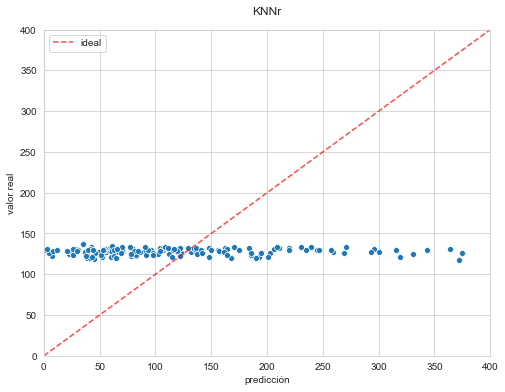

In [169]:
# Ver como es la comparación de los datos de predicción con los datos de test
plt.figure(figsize= (8,6))
sns.scatterplot(ytest, ypred2)
plt.plot((0,400), (0,400), '--', color= 'r', alpha= 0.7, label= 'ideal')
plt.ylim(0,400) 
plt.xlim(0,400)
plt.legend()
plt.title('KNNr' , pad= 15)
plt.ylabel('valor real')
plt.xlabel('predicción')

Text(0.5, 1.0, 'residuals range: -128.74 - 280.11, \n mean:-4.52, median: -25.4')

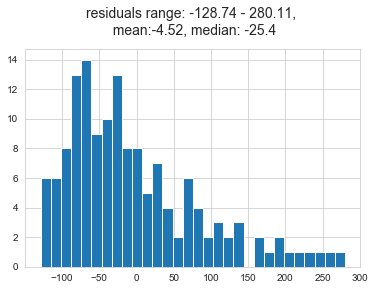

In [181]:
# ver cómo es la distribución de los residuales 
# si la predicción es buena deberían tener una distribución aproximadamente normal centrada en 0
diff = ytest - ypred2
diff.hist(bins= 30)
plt.title(f'residuals range: {np.round(min(diff),2)} - {np.round(max(diff),2)}, \n mean:{np.round(np.mean(diff), 2)}, median: {np.round(np.median(diff), 2)}',
         pad= 15, fontsize= 14)

 Si bien el RMSE es menor, el algoritmo predice todos valores acotados en un rango muy pequeño, esto se puede ver cuando analizamos la distribución de los residuales.

----------------------

### OPCIONAL 
(jugar con cantidad de n's viendo como varía el RMSE la mediana de los residuales)

In [68]:
iteraciones_knn = 200
err_knn = np.zeros(iteraciones_knn)
med_res_knn = np.zeros(iteraciones_knn)

In [69]:
# hago un for loop para ir entrenando un clasificador en cada iteracion e ir probando distintos valores de k
for r in range(0,iteraciones_knn):
    # entreno un KNN classifier con "k=r+1"
    neigh = KNeighborsRegressor(n_neighbors=r+1, weights= 'distance')
    neigh.fit(Xtrain_scal, ytrain)
    # calculo la prediccion
    ypred_knn = neigh.predict(Xtest_scal)
    # guardo el resultado de prediccion en la posicion r del vector "acc_knn"
    diff = ytest - ypred_knn
    err_knn[r] = np.sqrt(metrics.mean_squared_error(ytest, ypred_knn))
    med_res_knn[r] = np.median(diff)

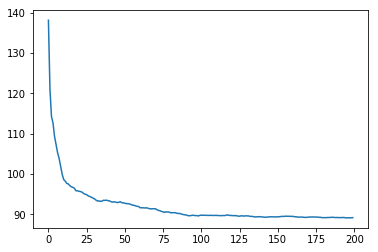

In [70]:
plt.plot(err_knn)
#plt.xlim(12,16)

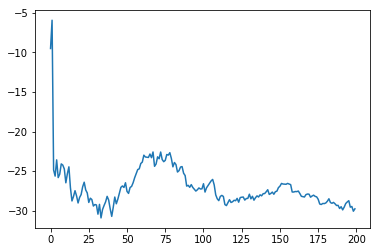

In [73]:
plt.plot(med_res_knn)

In [74]:
# Elegir el que parece mejor y fitear el modelo
neigh_opt = KNeighborsRegressor(n_neighbors= 60, weights= 'distance')

In [75]:
neigh_opt.fit(Xtrain_scal, ytrain)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=60, p=2,
                    weights='distance')

In [76]:
ypredkopt = neigh_opt.predict(Xtest_scal)

In [77]:
np.sqrt(metrics.mean_squared_error(ytest, ypredkopt))

91.90340438578052

(0, 400)

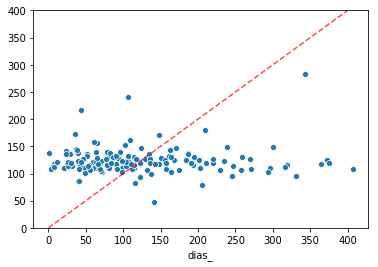

In [78]:
sns.scatterplot(ytest, ypredkopt)
#plt.xlim(0,200)
plt.plot((0,400), (0,400), '--', color= 'r', alpha= 0.7)
plt.ylim(0, 400)

Text(0.5, 1.0, 'residuals range: -173.38 - 299.33, \n mean:-0.29, median: -24.04')

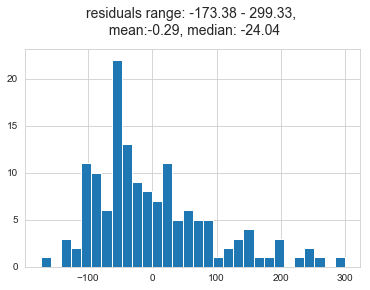

In [183]:
diff = ytest - ypredkopt
diff.hist(bins= 30)
plt.title(f'residuals range: {np.round(min(diff),2)} - {np.round(max(diff),2)}, \n mean:{np.round(np.mean(diff), 2)}, median: {np.round(np.median(diff), 2)}',
         pad= 15, fontsize= 14)

-------------------

## SVR

In [42]:
# SVR
svreg = SVR()

In [43]:
# generar diccionario de parámetros para el GridSearch
parameters_svr = [{'kernel':['rbf', 'linear'] , 'C': [50, 100, 1000],'gamma': [0.1,0.001, 1, 10], 'epsilon': [0.001, 0.01, 0.1, 1, 10]}]

In [44]:
regresor_svr = GridSearchCV(svreg, parameters_svr, cv= 5, verbose=True)

In [45]:
regresor_svr.fit(Xtrain_scal, ytrain)


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 30.1min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [50, 100, 1000],
                          'epsilon': [0.001, 0.01, 0.1, 1, 10],
                          'gamma': [0.1, 0.001, 1, 10],
                          'kernel': ['rbf', 'linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [46]:
regresor_svr.best_params_

{'C': 100, 'epsilon': 10, 'gamma': 10, 'kernel': 'rbf'}

In [48]:
ypred3 = regresor_svr.predict(Xtest_scal)


In [50]:
np.sqrt(metrics.mean_squared_error(ytest, ypred3))

90.63057202388345

Text(0.5, 0, 'predicción')

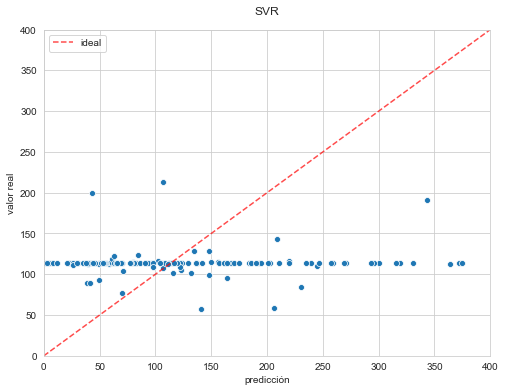

In [218]:
plt.figure(figsize= (8,6))
sns.scatterplot(ytest, ypred3)
plt.plot((0,400), (0,400), '--', color= 'r', alpha= 0.7, label= 'ideal')
plt.ylim(0,400) 
plt.xlim(0,400)
plt.legend()
plt.title('SVR' , pad= 15)
plt.ylabel('valor real')
plt.xlabel('predicción')

Text(0.5, 1.0, 'residuals range: -156.29 - 293.32, \n mean:9.53, median: -10.1')

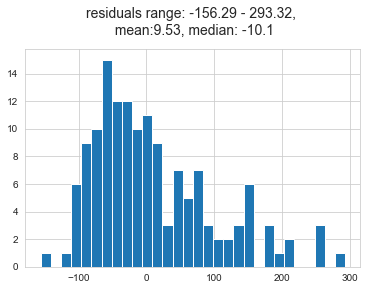

In [184]:
diff= ytest - ypred3
diff.hist(bins= 30)
plt.title(f'residuals range: {np.round(min(diff),2)} - {np.round(max(diff),2)}, \n mean:{np.round(np.mean(diff), 2)}, median: {np.round(np.median(diff), 2)}',
         pad= 15, fontsize= 14)

## Decision Tree

Nuevamente utilizando un Gridsearch y cross validation teníamos el mismo problema y el modelo se ajustaba dando un RMSE bajo pero porque ajustaba a "bandas discretas". Analizando y modificando los hiperparámetros manualmente llegamos al mejor modelo posible:

In [232]:
# Genero el objeto y lo entreno con los datos de entrenamiento
clf = tree.DecisionTreeRegressor(criterion= 'mse', min_samples_leaf= 4)
clf = clf.fit(Xtrain_scal, ytrain)

In [187]:
# Genero las predicciones a partir del set de test
y_clf = clf.predict(Xtest_scal)

In [188]:
# Calculo el RMSE
np.sqrt(metrics.mean_squared_error(ytest, y_clf))

95.22102046993257

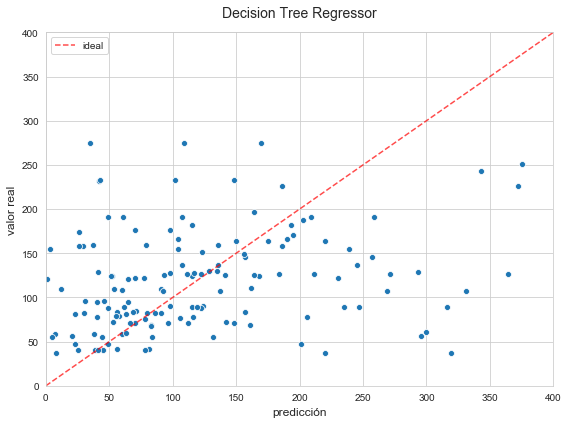

In [225]:
# Ver como es la comparación de los datos de predicción con los datos de test
plt.figure(figsize= (8,6))
sns.scatterplot(ytest, y_clf)
plt.plot((0,400), (0,400), '--', color= 'r', alpha= 0.7, label= 'ideal')
plt.ylim(0,400) 
plt.xlim(0,400)
plt.legend()
plt.title('Decision Tree Regressor' , pad= 15, fontsize= 14)
plt.ylabel('valor real', fontsize= 12, labelpad = 5)
plt.xlabel('predicción', fontsize= 12, labelpad = 5)
plt.tight_layout()
#plt.savefig('./figs/scatter_dtr.png', dpi= 300)

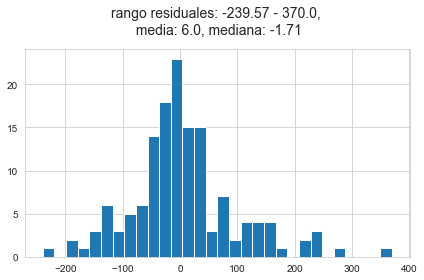

In [228]:
# ver cómo es la distribución de los residuales 
# si la predicción es buena deberían tener una distribución aproximadamente normal centrada en 0
diff = ytest - y_clf
diff.hist(bins= 30)
plt.title(f'rango residuales: {np.round(min(diff),2)} - {np.round(max(diff),2)}, \n media: {np.round(np.mean(diff), 2)}, mediana: {np.round(np.median(diff), 2)}',
         pad= 15, fontsize= 14)
plt.tight_layout()
#plt.savefig('./figs/residuales_dtr', dpi= 300)

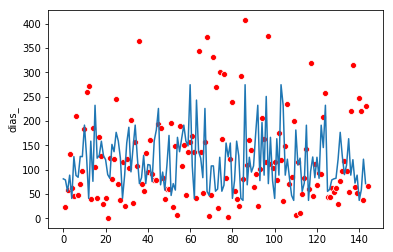

In [109]:
# Ver como predice el modelo a lo largo del set de test
sns.scatterplot(range(1, ytest.shape[0]+ 1), ytest, color= 'r')
plt.plot(clf.predict(Xtest_scal))

In [230]:
# setear el dataframe para poder mostrar como fittea el modelo a datos ordenados
Xtest_df = pd.DataFrame(Xtest_scal)
Xtest_df['y'] = ytest
Xtest_df.sort_values(by= 'y', ascending= False, inplace= True)

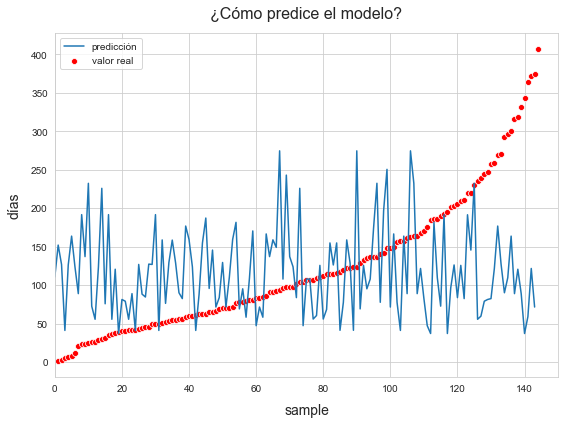

In [241]:
# Mostar como fitea el modelo a los datos ordenados. (no es bueno, sigue fitteando mas cerca de la media, predice mal hacia extremos)
plt.figure(figsize= (8,6))
sns.scatterplot(range(1, ytest.shape[0]+ 1), ytest.sort_values(), color= 'r', label= 'valor real')
plt.plot(clf.predict(Xtest_df.iloc[:,:-1]), label= 'predicción')
plt.legend(fontsize= 10)
plt.xlim(0,150)
plt.title('¿Cómo predice el modelo?', fontsize= 16, pad= 15)
plt.ylabel('días', fontsize= 14, labelpad= 10)
plt.xlabel('sample', fontsize= 14, labelpad= 10)
plt.tight_layout()
#plt.savefig('./figs/prediccion_dtr.png', dpi=300)

In [137]:
# Exportar árbol en formato dot para poder visualizarlo
import graphviz 
dot_data = tree.export_graphviz(clf, out_file='tree.dot', feature_names= X.columns) #,max_depth=4

## Boosting

In [81]:
from sklearn.ensemble import AdaBoostRegressor

In [102]:
# "Boostear" el árbol generado previamente utilizando un modelo de ensemble --> AdaBoost
# Hacer un Adaboost regressor
#regr_2 = AdaBoostRegressor(tree.DecisionTreeRegressor(criterion= 'mse', min_samples_leaf= 4, min_samples_split= 10), n_estimators=350)
#regr_2 = AdaBoostRegressor(tree.DecisionTreeRegressor(criterion= 'mse', max_depth=4, min_samples_leaf= 4), n_estimators=5000, learning_rate=0.05)
regr_2 = AdaBoostRegressor(tree.DecisionTreeRegressor(criterion= 'mse', max_depth= 1), n_estimators=5000, learning_rate= 0.05)
# Ver bien, criterion quantile

In [103]:
# Entreno con los datos de entrenamiento
regr_2.fit(Xtrain_scal, ytrain)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=1,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.05, loss='linear', n_estimators=5000,
                  rando

In [104]:
# Genero las predicciones a partir del set de test
ada_y = regr_2.predict(Xtest_scal)

In [105]:
# Calculo el RMSE
np.sqrt(metrics.mean_squared_error(ytest, ada_y))

93.54696980182062

Text(0.5, 0, 'predicción')

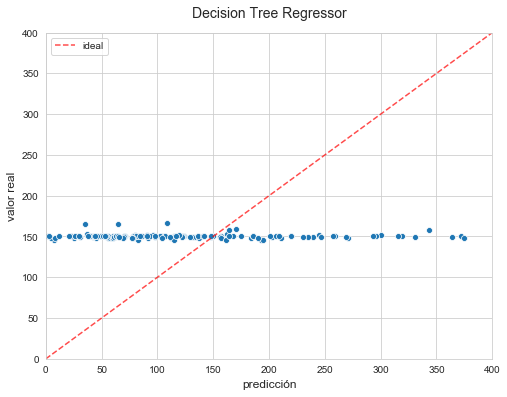

In [242]:
# Ver como es la comparación de los datos de predicción con los datos de test
plt.figure(figsize= (8,6))
sns.scatterplot(ytest, ada_y)
plt.plot((0,400), (0,400), '--', color= 'r', alpha= 0.7, label= 'ideal')
plt.ylim(0,400) 
plt.xlim(0,400)
plt.legend()
plt.title('Decision Tree Regressor' , pad= 15, fontsize= 14)
plt.ylabel('valor real', fontsize= 12, labelpad = 5)
plt.xlabel('predicción', fontsize= 12, labelpad = 5)


Text(0.5, 1.0, 'residuals range: -149.58 - 256.58, \n mean:-27.2, median: -49.8')

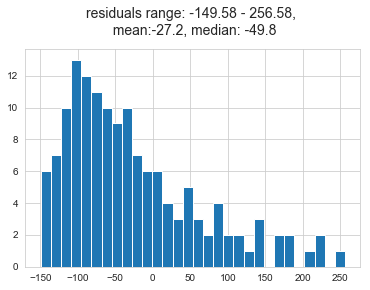

In [191]:
# ver cómo es la distribución de los residuales 
# si la predicción es buena deberían tener una distribución aproximadamente normal centrada en 0
diff = ytest - ada_y
diff.hist(bins= 30)
plt.title(f'residuals range: {np.round(min(diff),2)} - {np.round(max(diff),2)}, \n mean:{np.round(np.mean(diff), 2)}, median: {np.round(np.median(diff), 2)}',
         pad= 15, fontsize= 14)

## Random Forest

In [135]:
# Genero un objeto random Forest con el mismo arbol que funcionó bien
rfr_ = rfr(n_estimators = 100, min_samples_leaf= 4, bootstrap = False) # , min_samples_split= 10, bootstrap = False, oob_score = True, warm_start = True

In [136]:
# Entreno con los datos de entrenamiento
rfr_.fit(Xtrain_scal, ytrain)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [137]:
# Genero las predicciones a partir del set de test
rfr_y = rfr_.predict(Xtest_scal)

In [138]:
# Calculo el RMSE
np.sqrt(metrics.mean_squared_error(ytest, rfr_y))

95.22102046993257

Text(0.5, 0, 'predicción')

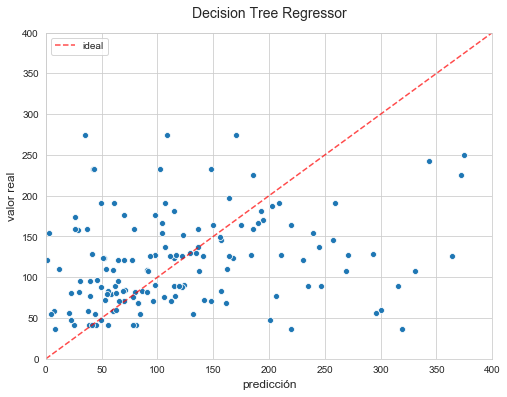

In [243]:
# Ver como es la comparación de los datos de predicción con los datos de test
plt.figure(figsize= (8,6))
sns.scatterplot(ytest, rfr_y)
plt.plot((0,400), (0,400), '--', color= 'r', alpha= 0.7, label= 'ideal')
plt.ylim(0,400) 
plt.xlim(0,400)
plt.legend()
plt.title('Decision Tree Regressor' , pad= 15, fontsize= 14)
plt.ylabel('valor real', fontsize= 12, labelpad = 5)
plt.xlabel('predicción', fontsize= 12, labelpad = 5)


Text(0.5, 1.0, 'residuals range: -239.57 - 370.0, \n mean:6.0, median: -1.71')

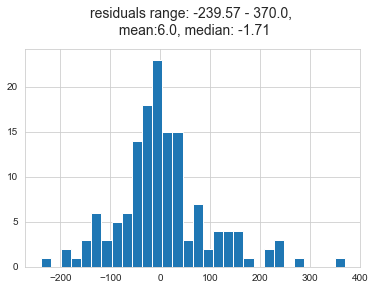

In [192]:
# ver cómo es la distribución de los residuales 
# si la predicción es buena deberían tener una distribución aproximadamente normal centrada en 0
diff = ytest - rfr_y
diff.hist(bins= 30)
plt.title(f'residuals range: {np.round(min(diff),2)} - {np.round(max(diff),2)}, \n mean:{np.round(np.mean(diff), 2)}, median: {np.round(np.median(diff), 2)}',
         pad= 15, fontsize= 14)

En general todos los modelos, predigan mejor o peor los datos, se comportan mal con los valores altos 

# PCA

Calcular los componentes principales y ver si los modelos predicen mejor utilizando estos.

In [196]:
from sklearn.decomposition import PCA

In [197]:
# Generar el objeto con 10 componentes principales
pca = PCA(n_components= 10)

In [198]:
# Calcular los componentes principales de mi matriz de datos
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [199]:
print(f'los primeros dos componentes principales explican un {pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]} de la variabilidad')

los primeros dos componentes principales explican un 0.9624046488416271 de la variabilidad


In [200]:
# Transformar los datos
X_pca = pca.transform(X)

In [201]:
# Ver la forma del dataframe obtenido
X_pca.shape

(720, 10)

In [202]:
# voy a quedarme solo con los dos primeros componentes principales
# transformo a dataframe para trabajar con más facilidad
X_pca = pd.DataFrame(X_pca, columns = [n for n in range(10)])
# me quedo con las dos primeras columnas
X_pca = X_pca[[0,1]]

In [203]:
# Generar bins para poder estratificar la variable continua y tener representados todos los valores en el train test
bins = np.linspace(0, max(y)+ 1, 25)
y_binned = np.digitize(y, bins)

In [204]:
# Train test split
Xpcatrain, Xpcatest, ytrain, ytest = train_test_split(X_pca, y, test_size=0.2, random_state=7, stratify= y_binned)

## Linear regression

In [205]:
lr.fit(Xpcatrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [206]:
pcapred = lr.predict(Xpcatest)

In [207]:
np.sqrt(metrics.mean_squared_error(ytest, pcapred))

89.36591983158894

Text(0.5, 0, 'predicción')

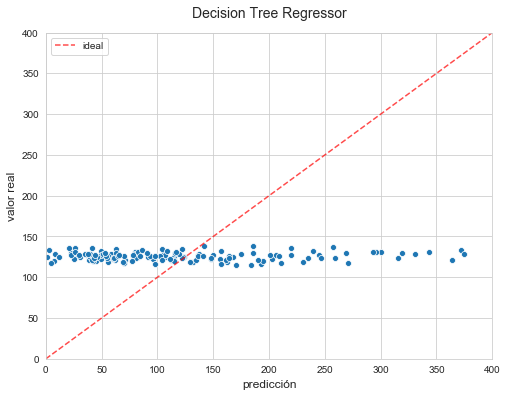

In [244]:
plt.figure(figsize= (8,6))
sns.scatterplot(ytest, pcapred)
plt.plot((0,400), (0,400), '--', color= 'r', alpha= 0.7, label= 'ideal')
plt.ylim(0,400) 
plt.xlim(0,400)
plt.legend()
plt.title('Decision Tree Regressor' , pad= 15, fontsize= 14)
plt.ylabel('valor real', fontsize= 12, labelpad = 5)
plt.xlabel('predicción', fontsize= 12, labelpad = 5)


Text(0.5, 1.0, 'residuals range: -131.01 - 278.86, \n mean:-2.63, median: -23.72')

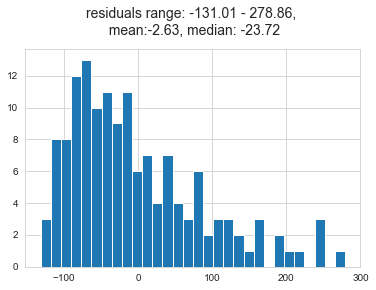

In [209]:
# ver cómo es la distribución de los residuales 
# si la predicción es buena deberían tener una distribución aproximadamente normal centrada en 0
diff = ytest - pcapred
diff.hist(bins= 30)
plt.title(f'residuals range: {np.round(min(diff),2)} - {np.round(max(diff),2)}, \n mean:{np.round(np.mean(diff), 2)}, median: {np.round(np.median(diff), 2)}',
         pad= 15, fontsize= 14)

## Decision Tree

In [211]:
# Genero el objeto y lo entreno con los datos de entrenamiento
clf = tree.DecisionTreeRegressor(criterion= 'mse', min_samples_leaf= 4)
clf = clf.fit(Xpcatrain, ytrain)

In [212]:
# Genero las predicciones a partir del set de test
y_pcaclf = clf.predict(Xpcatest)

In [213]:
# Calculo el RMSE
np.sqrt(metrics.mean_squared_error(ytest, y_pcaclf))

107.61353960743283

Text(0.5, 0, 'predicción')

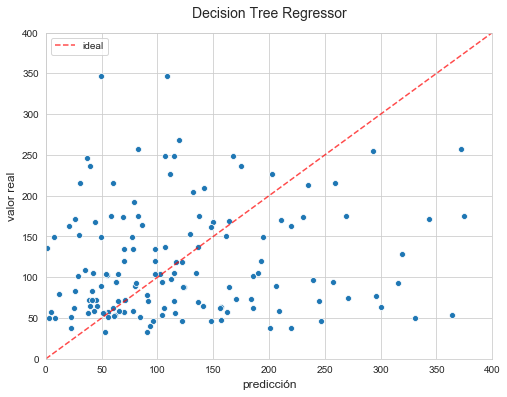

In [245]:
# Ver como es la comparación de los datos de predicción con los datos de test
plt.figure(figsize= (8,6))
sns.scatterplot(ytest, y_pcaclf)
plt.plot((0,400), (0,400), '--', color= 'r', alpha= 0.7, label= 'ideal')
plt.ylim(0,400) 
plt.xlim(0,400)
plt.legend()
plt.title('Decision Tree Regressor' , pad= 15, fontsize= 14)
plt.ylabel('valor real', fontsize= 12, labelpad = 5)
plt.xlabel('predicción', fontsize= 12, labelpad = 5)


Text(0.5, 1.0, 'residuals range: -298.0 - 374.25, \n mean:7.05, median: -2.33')

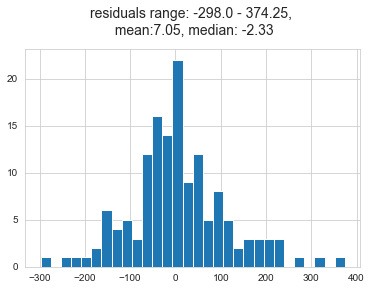

In [215]:
# ver cómo es la distribución de los residuales 
# si la predicción es buena deberían tener una distribución aproximadamente normal centrada en 0
diff = ytest - y_pcaclf
diff.hist(bins= 30)
plt.title(f'residuals range: {np.round(min(diff),2)} - {np.round(max(diff),2)}, \n mean:{np.round(np.mean(diff), 2)}, median: {np.round(np.median(diff), 2)}',
         pad= 15, fontsize= 14)

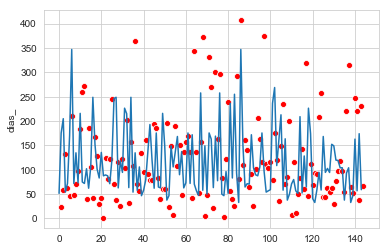

In [216]:
# Ver como es el modelo realmente
sns.scatterplot(range(1, ytest.shape[0]+ 1), ytest, color= 'r')
plt.plot(clf.predict(Xpcatest))


No mejora la predicción